### Basic Test - simple paralle graph


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History, Incremental
from primeGraph import Graph, START, END
import time

from rich import print as rprint

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class StateForTestWithHistory(GraphState):
    execution_order: History[str]
    counter: Incremental[int]

state = StateForTestWithHistory(execution_order=[], counter=0)

def test_graph(storage=None):
    graph = Graph(state=state, checkpoint_storage=storage)

    @graph.node()
    def task1(state):
        time.sleep(1)
        print("task1")
        return {"execution_order": "task1", "counter": 1}

    @graph.node(interrupt="after")
    def task2(state):
        time.sleep(2)
        print("task2")
        return {"execution_order": "task2"}

    @graph.node()
    def task3(state):
        time.sleep(2)
        print("task3")
        return {"execution_order": "task3"}

    @graph.node()
    def task4(state):
        time.sleep(1)
        print("task4")
        return {"execution_order": "task4"}
    
    @graph.node()
    def task5(state):
        time.sleep(1)
        print("task5")
        return {"execution_order": "task5"}
    
    @graph.node()
    def task6(state):
        time.sleep(1)
        print("task6")
        return {"execution_order": "task6"}

    # Create parallel paths
    graph.add_edge(START, "task1")
    graph.add_edge("task1", "task2")
    graph.add_edge("task1", "task3")
    graph.add_edge("task2", "task4")
    graph.add_edge("task3", "task5")
    graph.add_edge("task4", "task6")
    graph.add_edge("task5", "task6")
    graph.add_edge("task6", END)

    graph.compile()

    return graph


In [ ]:
from primeGraph.checkpoint.local_storage import LocalStorage

graph = test_graph(storage=LocalStorage())
graph.visualize()

In [ ]:
rprint(await graph.execute())
rprint(graph.state)

In [ ]:
import asyncio

# Add debug logging
logging.getLogger('primeGraph.checkpoint.local_storage').setLevel(logging.DEBUG)
logging.getLogger('primeGraph.graph.engine').setLevel(logging.DEBUG)


task = asyncio.create_task(executor.execute())

# Wait a bit and print engine state before checkpoint
await asyncio.sleep(4)
print("\n=== Engine State BEFORE checkpoint ===")
rprint(executor.get_full_state())

# Print checkpoint state right after it's saved
await asyncio.sleep(0.1)  # Small delay to ensure checkpoint is saved
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]
print("\n=== Checkpoint State ===")
rprint(checkpoint_state.engine_state)

# Wait a bit longer for task5 to complete
await asyncio.sleep(2)
print("\n=== Engine State AFTER task5 completion ===")
rprint(executor.get_full_state())

### Basic Test - parellel test


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History, Incremental, LastValue
from primeGraph import Graph, START, END


from rich import print as rprint

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class SubgraphState(GraphState):
    execution_order: History[str]
    counter: Incremental[int]
    status: LastValue[str]

def test_graph(storage=None):
    state = SubgraphState(execution_order=[], counter=0, status="")
    main_graph = Graph(state=state)

    # Create a subgraph
    @main_graph.subgraph()
    def processing_subgraph():
        subgraph = Graph(state=state)

        @subgraph.node()
        def process_a(state):
            return {"execution_order": "process_a", "counter": 1}

        @subgraph.node()
        def process_b(state):
            return {"execution_order": "process_b", "counter": 2}

        subgraph.add_edge(START, "process_a")
        subgraph.add_edge("process_a", "process_b")
        subgraph.add_edge("process_b", END)

        return subgraph

    # Main graph nodes
    @main_graph.node()
    def start_task(state):
        return {"execution_order": "start_task", "status": "started"}

    @main_graph.node()
    def end_task(state):
        return {"execution_order": "end_task", "status": "completed"}

    # Connect main graph
    main_graph.add_edge(START, "start_task")
    main_graph.add_edge("start_task", "processing_subgraph")
    main_graph.add_edge("processing_subgraph", "end_task")
    main_graph.add_edge("end_task", END)

    main_graph.compile()

    return main_graph

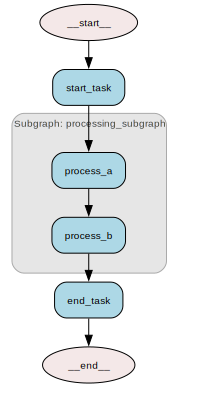

In [2]:
from primeGraph.checkpoint.local_storage import LocalStorage

graph = test_graph(storage=LocalStorage())
graph.visualize()

In [ ]:
rprint(graph.nodes)

In [ ]:
rprint(graph.edges)

In [3]:
rprint(graph.edges_map)

defaultdict(<class 'list'>, {
    '__start__': ['start_task'],
    'start_task': ['processing_subgraph_process_a', 'processing_subgraph_process_a'],
    'processing_subgraph_process_a': ['processing_subgraph_process_b', 'processing_subgraph_process_b'],
    'processing_subgraph_process_b': ['end_task', 'end_task'],
    'end_task': ['__end__']
})

In [ ]:
await graph.execute()
rprint(graph.state)

In [ ]:
rprint(await graph.resume())
rprint(graph.state)
rprint(graph.execution_engine.get_full_state())

In [ ]:
import asyncio

exec_task = asyncio.create_task(graph.execute())

if exec_task.done():
    print("Task is done!")


In [ ]:
graph.state

### Basic Test - parellel test


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History, Incremental, LastValue
from primeGraph import Graph, START, END


from rich import print as rprint

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class SubgraphState(GraphState):
    execution_order: History[str]
    counter: Incremental[int]
    status: LastValue[str]

def test_graph(storage=None):
    state = SubgraphState(execution_order=[], counter=0, status="")
    main_graph = Graph(state=state)

    # Create first subgraph
    @main_graph.subgraph()
    def subgraph_a():
        subgraph = Graph(state=state)

        @subgraph.node()
        def process_1(state):
            return {"execution_order": "process_1", "counter": 1}

        @subgraph.node()
        def process_2(state):
            return {"execution_order": "process_2", "counter": 2}

        subgraph.add_edge(START, "process_1")
        subgraph.add_edge("process_1", "process_2")
        subgraph.add_edge("process_2", END)

        return subgraph

    # Create second subgraph
    @main_graph.subgraph()
    def subgraph_b():
        subgraph = Graph(state=state)

        @subgraph.node()
        def process_3(state):
            return {"execution_order": "process_3", "counter": 3}

        @subgraph.node()
        def process_4(state):
            return {"execution_order": "process_4", "counter": 4}

        subgraph.add_edge(START, "process_3")
        subgraph.add_edge("process_3", "process_4")
        subgraph.add_edge("process_4", END)

        return subgraph

    # Main graph nodes
    @main_graph.node()
    def initialize(state):
        return {"execution_order": "initialize", "status": "started"}

    @main_graph.node()
    def finalize(state):
        return {"execution_order": "finalize", "status": "completed"}

    # Connect main graph with parallel subgraphs
    main_graph.add_edge(START, "initialize")
    main_graph.add_edge("initialize", "subgraph_a")
    main_graph.add_edge("initialize", "subgraph_b")
    main_graph.add_edge("subgraph_a", "finalize")
    main_graph.add_edge("subgraph_b", "finalize")
    main_graph.add_edge("finalize", END)

    main_graph.compile()

    return main_graph

In [ ]:
from primeGraph.checkpoint.local_storage import LocalStorage

graph = test_graph(storage=LocalStorage())
graph.visualize()

In [ ]:
rprint(graph.nodes)

In [ ]:
rprint(graph.edges)

In [ ]:
rprint(graph.edges_map)

In [ ]:
await graph.execute()
rprint(graph.state)

In [ ]:
rprint(await graph.resume())
rprint(graph.state)
rprint(graph.execution_engine.get_full_state())

In [ ]:
import asyncio

exec_task = asyncio.create_task(graph.execute())

if exec_task.done():
    print("Task is done!")


In [ ]:
graph.state

### Router node


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History, LastValue
from primeGraph import Graph, START, END
from primeGraph.graph.engine import GraphExecutor
import time

from rich import print as rprint

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class RouterState(GraphState):
    result: LastValue[dict]  # Store the result from routes
    execution_order: History[str]  # Track execution order


def test_graph(storage=None):
    state = RouterState(result={}, execution_order=[])
    graph = Graph(state=state, checkpoint_storage=storage)

    @graph.node()
    def process_data(state):
        print("process_data")
        if True:
            return "route_a"  # Router node returns next node name
        else:
            return "route_b"

    @graph.node()
    def route_a(state):
        print("route_a")
        time.sleep(0.1)
        return {
            "result": {"path": "A"},
            "execution_order": "route_a",
        }

    @graph.node()
    def route_b(state):
        print("route_b")
        time.sleep(0.1)
        return {
            "result": {"path": "B"},
            "execution_order": "route_b",
        }

    # Add router edge and possible routes
    
    graph.add_edge("route_a", END)
    graph.add_edge("route_b", END)
    graph.add_router_edge(START, "process_data")

    graph.compile()

    return graph


In [ ]:
from primeGraph.checkpoint.local_storage import LocalStorage

graph = test_graph(storage=LocalStorage())
graph.visualize()

In [ ]:
import asyncio

# Add debug logging
logging.getLogger('primeGraph.checkpoint.local_storage').setLevel(logging.DEBUG)
logging.getLogger('primeGraph.graph.engine').setLevel(logging.DEBUG)

executor = GraphExecutor(graph)
task = asyncio.create_task(executor.execute())

# Wait a bit and print engine state before checkpoint
await asyncio.sleep(4)
print("\n=== Engine State BEFORE checkpoint ===")
rprint(executor.get_full_state())

# Print checkpoint state right after it's saved
await asyncio.sleep(0.1)  # Small delay to ensure checkpoint is saved
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]
print("\n=== Checkpoint State ===")
rprint(checkpoint_state.engine_state)

# Wait a bit longer for task5 to complete
await asyncio.sleep(2)
print("\n=== Engine State AFTER task5 completion ===")
rprint(executor.get_full_state())

In [ ]:
executor.resume()

In [ ]:
rprint(executor.get_full_state())

In [ ]:
rprint(graph.checkpoint_storage._storage)

In [ ]:
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
last_checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]

executor = GraphExecutor(graph)

executor.load_full_state(last_checkpoint_state.engine_state)
rprint(executor.get_full_state())

In [ ]:
executor.resume()
await executor.execute()

In [ ]:
graph.chain_status

### Router node


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph import Graph, START, END
from pydantic import Field, BaseModel
from primeGraph.models import GraphState
from primeGraph.buffer import History, LastValue
from rich import print as rprint
from typing import Dict, Union, List, Any
from primeGraph.checkpoint.postgresql import PostgreSQLStorage
from primeGraph.graph.engine import GraphExecutor
from rich import print as rprint
import instructor
from openai import OpenAI

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

sys_prompt_start = """
You are a helpful assistant that is able to help the user with their goals.

You are part of a workflow for the user to plan for something. This is the first step of the workflow.

Give the user a welcome in a brief way and prepare them to start sharing their goal. Things you need to let the user know:

- They should share their goal in a clear and concise manner
- [OPTIONAL] they should share any relevant context or details about the goal
- [OPTIONAL] They should express what success looks like for this goal
- [OPTIONAL] They should share any constraints or requirements for the goal
"""

sys_prompt_process_message = """

==== OVERALL GUIDANCE =====
You are in a planning workflow in this is the second (and more important) step.

Your goal is to analyze the user's message and route them to the next step in the workflow.

You will be given the user's message and the conversation history. Give more weight to the user's message than the conversation history.

__ The main goal for this entire planning process: __

- Break down the user goal in the planning steps that are:
    - Clear
    - Concise
    - Easy to understand
    - Easy to follow

__ The main goal with this step is to: __

- Analyze current information about the goal and the conversation history
- Assess if the information gathered is enough to create a good plan
- Route user to the next step in the workflow
- Make sure you capture user's intent and route them to the correct step
- Make the user experience seemless and seamless

==== WORKFLOW STEPS =====

Everything evolve around you capacity to create a good plan in the end. 
Based on the information gathered, evaluate the following:

IF information about the goal, details, or anything that can help you create a good plan is needed:
- [Follow up questions]
    - Ask follow up questions to gather more information about the goal
    - Analyze all the information gathered and judge if addional information is needed
    - Be clear and concise with the follow up questions

IF all the information is gathered and/or the user is ready to move forward, choose between:
- [Summarize and ask permission]: 
    - Help the user visualize the high level plan
    - Share your plan into macro steps with a brief summary of what each step entails
    - Check if the user would like to proceed with the next step
- [Finalize]: If the summary is approved, or the user is saying that they are ready to move forward, you should proceed to the next step

Unrelated:
- [Outside of the workflow]: The user is explicitly asking to move out of the plan workflow or explicitly saying that they are done or want to cancel.


==== GUIDELINES ON HOW TO ACT =====

- Pay extreme attention to the user's message
- Try to understand the user's intent
- Always pick only ONE of the options presented to you on WORKFLOW STEPS

"""

sys_prompt_followup = """
==== OVERALL GUIDANCE =====
You are in a planning workflow and this is a follow up step.

Your goal is to analyze the user's goal, the information gathered and the conversation history.
Based on the information gathered, you should ask follow up questions to gather more information about the goal.


__ The main goal for this entire planning process: __

- Break down the user goal in the planning steps that are:
    - Clear
    - Concise
    - Easy to understand
    - Easy to follow

__ The main goal with this step is to: __

- Analyze current information
- Make additional follow up questions ONLY IF NEEDED
    - The act of gather more information should be to make sure that the planning process has its goals achieved

==== GUIDELINES ON HOW TO ACT =====

- Pay extreme attention to all the curren information gathered
- Identify the gaps into a good planning to achieve the goal and the information needed to fill those gaps
- Make follow up questions ONLY IF NEEDED
    - The act of gather more information should be to make sure that the planning process has its goals achieved

"""

sys_prompt_summarize = """
==== OVERALL GUIDANCE =====
You are in a planning workflow and this is a summarize step.

Your goal is to share with the user a high level overview of the plan you are about to create.
Make it short anc concise, but also include all the important details.
Make it visually easy to understand and review (on the user's end). 
Ask if the user would like to proceed with the next step.


__ The main goal for this entire planning process: __

- Break down the user goal in the planning steps that are:
    - Clear
    - Concise
    - Easy to understand
    - Easy to follow

__ The main goal with this step is to: __

- Summarize the plan in a way that is easy to understand and review
- Make it visually easy to understand and review (on the user's end)
- Ask if the user would like to proceed with the next step

==== GUIDELINES ON HOW TO ACT =====

- Make sure you include all the important details
- Make sure you have a decent break down of the plan
- Make it visually easy to understand and review (on the user's end)
- Ask if the user would like to proceed with the next step
"""

sys_prompt_finalize = """
==== OVERALL GUIDANCE =====
You are in a planning workflow and this is a finalize step.

Your goal is to say goodbye to the user and thank them for using your service.
"""


class PlannerState(GraphState):
    conversation: History[Dict[str, str]] = Field(default_factory=list)
    model_message: LastValue[Union[str, None]] = Field(
        default=None
    )  # Should be consumed by the bot before moving forward interruptions
    user_message: LastValue[Union[str, None]] = Field(
        default=None
    )  # Should be consumed by the bot before moving forward interruptions
    is_followup: LastValue[Union[None, bool]] = Field(default=None)
    is_summarize: LastValue[Union[bool, None]] = Field(default=None)
    is_finalize: LastValue[Union[bool, None]] = Field(default=None)
    is_outside_of_the_workflow: LastValue[Union[bool, None]] = Field(default=None)
    plan_goal: LastValue[str] = Field(default="")
    plan_summary: LastValue[str] = Field(default="")
    plan_steps: LastValue[List[str]] = Field(default_factory=list)
    plan_details: History[str] = Field(default_factory=list)
    current_information_assessment: LastValue[str] = Field(default="")
    follow_up_questions: LastValue[List[str]] = Field(default_factory=list)
    plan_summary: LastValue[str] = Field(default="")
    plan_steps: LastValue[List[str]] = Field(default_factory=list)

def planner_graph(graph_state: PlannerState, checkpoint_storage: Union[PostgreSQLStorage, None]) -> Graph:
    plan_graph = Graph(state=graph_state, verbose=True, checkpoint_storage=checkpoint_storage)
    client = instructor.from_openai(OpenAI())

    @plan_graph.node(interrupt="after")
    def start_conversation(state: PlannerState) -> dict[str, Any]:
        class StartConversationResponse(BaseModel):
            response: str = Field(description="Your response to the user")

        completion = client.chat.completions.create(
            model="gpt-4o",
            response_model=StartConversationResponse,
            messages=[
                {"role": "system", "content": sys_prompt_start},
            ],
        )
        return {"conversation": {"role": "assistant", "content": completion.response}}

    @plan_graph.node()
    def process_user_message(state: PlannerState) -> dict[str, Any]:
        class ProcessMessageResponse(BaseModel):
            plan_goal: str = Field(description="The main goal of the plan")
            plan_details: List[str] = Field(description="Any additional relevant details of the plan")
            is_followup: bool # = Field(description="If you need to ask follow up questions")
            is_summarize: bool # = Field(description="If there are not follow up questions on your end.")
            is_finalize: bool # = Field(
            #     description="If the user is explicitly asking to move out of the plan workflow"
            # )
            is_outside_of_the_workflow: bool # = Field(
            #     description="If the user is explicitly asking to move out of the plan workflow"
            # )

        # add user message to the conversation
        if state.user_message:
            state.conversation.append({"role": "user", "content": state.user_message})

        # Extract structured data from natural language
        completion = client.chat.completions.create(
            model="gpt-4o",
            response_model=ProcessMessageResponse,
            messages=[
                {"role": "system", "content": sys_prompt_process_message},
                *state.conversation,
                {"role": "user", "content": state.user_message},
            ],
        )

        # unpack plan_details:
        if completion.plan_details:
            for detail in completion.plan_details:
                state.plan_details.append(detail)

        return {
            "plan_goal": completion.plan_goal,
            "user_message": None,
            "model_message": None,
            "is_followup": completion.is_followup,
            "is_summarize": completion.is_summarize,
            "is_finalize": completion.is_finalize,
            "is_outside_of_the_workflow": completion.is_outside_of_the_workflow,
        }

    @plan_graph.node()
    def response_router(state: PlannerState) -> str:
        if state.is_finalize:
            return "finalize_plan"
        elif state.is_summarize:
            return "summarize_plan"
        elif state.is_followup:
            return "make_followup_questions"
        else:
            return "process_user_message"
                
    @plan_graph.node(interrupt="after")
    def make_followup_questions(state: PlannerState):
        class FollowupResponse(BaseModel):
            plan_goal: str = Field(description="The main goal of the plan")
            plan_details: List[str] = Field(description="Any additional you got from your interactions with the user")
            current_information_assessment: str = Field(description="A brief assessment of the current information gathered")
            follow_up_questions: List[str] = Field(description="The follow up questions that you think are needed to gather more information about the goal")
            response: str = Field(description="Your response with the follow up questions")

    
        completion = client.chat.completions.create(
            model="gpt-4o",
            response_model=FollowupResponse,
            messages=[
                {"role": "system", "content": sys_prompt_followup},
                *state.conversation,
                {"role": "user", "content": state.user_message},
            ],
        )
        
        # unpack plan_details:
        if completion.plan_details:
            for detail in completion.plan_details:
                state.plan_details.append(detail)

        return {
            "conversation": {"role": "assistant", "content": completion.response},
            "user_message": None,
            "model_message": completion.response,
            "current_information_assessment": completion.current_information_assessment,
            "follow_up_questions": completion.follow_up_questions,
        }
  
    @plan_graph.node(interrupt="after")
    def summarize_plan(state: PlannerState):
        class SummarizeResponse(BaseModel):
            response: str = Field(description="Your response to the user")
            plan_summary: str = Field(description="A summary of the plan")
            plan_steps: List[str] = Field(description="A list of the steps that are part of the plan")

            
        # Extract structured data from natural language

        completion = client.chat.completions.create(
            model="gpt-4o",
            response_model=SummarizeResponse,
            messages=[
                {"role": "system", "content": sys_prompt_summarize},
                *state.conversation,
                {"role": "user", "content": state.user_message},
            ],
        )
    
        return {
            "conversation": {"role": "assistant", "content": completion.response},
            "user_message": None,
            "model_message": completion.response,
            "plan_summary": completion.plan_summary,
            "plan_steps": completion.plan_steps,
        }
    
    @plan_graph.node()
    def finalize_plan(state: PlannerState):
        class FinalizeResponse(BaseModel):
            response: str = Field(description="Your response to the user")

        completion = client.chat.completions.create(
            model="gpt-4o",
            response_model=FinalizeResponse,
            messages=[
                {"role": "system", "content": sys_prompt_finalize},
            ],
        )

        return {
            "conversation": {"role": "assistant", "content": completion.response},
            "user_message": None,
            "model_message": completion.response,
        }


    plan_graph.add_edge(START, "start_conversation")
    plan_graph.add_edge("start_conversation", "process_user_message")
    plan_graph.add_router_edge("process_user_message", "response_router")

    plan_graph.add_edge("summarize_plan", "process_user_message")
    plan_graph.add_edge("make_followup_questions", "process_user_message")
    plan_graph.add_edge("finalize_plan", END)
    
    plan_graph.compile()

    return plan_graph


In [ ]:
from primeGraph.checkpoint.local_storage import LocalStorage

graph = planner_graph(checkpoint_storage=LocalStorage(), graph_state=PlannerState())
graph.visualize()

In [ ]:
rprint(graph.state)

In [ ]:
executor = GraphExecutor(graph)

await executor.execute()
rprint(graph.state)

In [ ]:
await executor.resume()
rprint(graph.state)

In [ ]:
await executor.resume()
rprint(graph.state)

In [ ]:
import asyncio

# Add debug logging
logging.getLogger('primeGraph.checkpoint.local_storage').setLevel(logging.DEBUG)
logging.getLogger('primeGraph.graph.engine').setLevel(logging.DEBUG)

executor = GraphExecutor(graph)
task = asyncio.create_task(executor.execute())

# Wait a bit and print engine state before checkpoint
await asyncio.sleep(4)
print("\n=== Engine State BEFORE checkpoint ===")
rprint(executor.get_full_state())

# Print checkpoint state right after it's saved
await asyncio.sleep(0.1)  # Small delay to ensure checkpoint is saved
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]
print("\n=== Checkpoint State ===")
rprint(checkpoint_state.engine_state)

# Wait a bit longer for task5 to complete
await asyncio.sleep(2)
print("\n=== Engine State AFTER task5 completion ===")
rprint(executor.get_full_state())

In [ ]:
executor.resume()

In [ ]:
rprint(executor.get_full_state())

In [ ]:
rprint(graph.state)

In [ ]:
rprint(graph.checkpoint_storage._storage)

In [ ]:
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
last_checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]

executor = GraphExecutor(graph)

executor.load_full_state(last_checkpoint_state.engine_state)
rprint(executor.get_full_state())

In [ ]:
executor.resume()
await executor.execute()

In [ ]:
graph.chain_status